  0%|          | 3/600 [00:00<00:24, 24.82it/s]

Start of training on 15.05.2021 , 18:13:56


  0%|          | 3/600 [00:00<00:22, 26.21it/s]

epoch : 1 of 3 , learning rate: 0.01 , runtime: 24.72 seconds
training loss: 0.0012, acc 0.9633 
validation loss: 0.0004, validation acc 0.9877 


  0%|          | 3/600 [00:00<00:22, 26.19it/s]

epoch : 2 of 3 , learning rate: 0.01 , runtime: 24.51 seconds
training loss: 0.0004, acc 0.9886 
validation loss: 0.0003, validation acc 0.9927 


100%|██████████| 600/600 [00:22<00:00, 26.42it/s]


epoch : 3 of 3 , learning rate: 0.01 , runtime: 24.96 seconds
training loss: 0.0003, acc 0.9918 
validation loss: 0.0002, validation acc 0.9932 
End of training on 15.05.2021 , 18:15:10


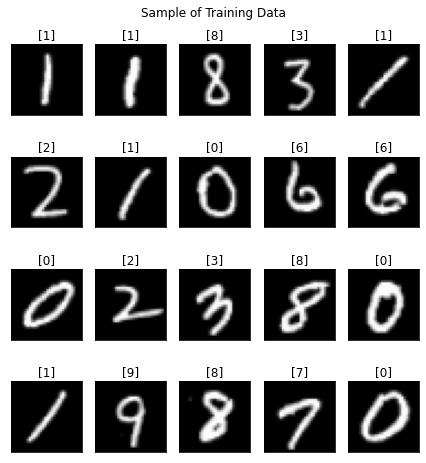

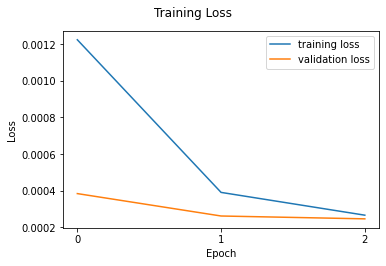

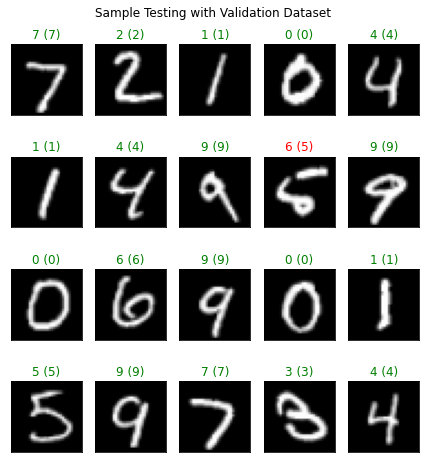

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from datetime import date
import time

# Define Model
cfg = {
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, in_channels):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name],in_channels)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg, in_channels):
        layers = []
        in_channels = in_channels
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

def detach(tensor):
  tensor.cpu().clone().detach()

if __name__ == '__main__':
  # Load MNIST Dataset
  transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
  training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size =100, shuffle=False)


  # Displaying images from training data  
  dataiter = iter(training_loader)
  images, labels = dataiter.next()
  fig = plt.figure(figsize=(6,7))
  for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])
    plt.tight_layout(1.0)
    plt.suptitle("Sample of Training Data")

# Training parameters
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = VGG('VGG19',in_channels=1).to(device)

  print_lr = 0.01
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = print_lr,momentum=0.9, weight_decay=5e-4)

  epochs = 3
  running_loss_history = []
  running_corrects_history = []
  val_running_loss_history = []
  val_running_corrects_history = []

# Training Loop
  print("Start of training on", date.today().strftime("%d.%m.%Y"),",",datetime.now().strftime("%H:%M:%S"))
  for e in range(epochs):
    if e>0 and (e<(epochs-1)) and (e%7==0):  
      for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.1
        print_lr = param_group['lr']

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    epoch_start_time = time.time()
    
    for inputs, labels in tqdm(training_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)

      detach(inputs)
      detach(labels)
      detach(val_inputs)
      detach(val_labels)
      del inputs
      del labels
      del val_inputs
      del val_labels    
      torch.cuda.empty_cache()  

      epoch_run_time = round(time.time() - epoch_start_time,2)
      epoch_loss = running_loss/len(training_loader.dataset)
      epoch_acc = running_corrects.float()/ len(training_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      
      val_epoch_loss = val_running_loss/len(validation_loader.dataset)
      val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1),"of",epochs,", learning rate:",print_lr,", runtime:",epoch_run_time,"seconds")
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
  print("End of training on", date.today().strftime("%d.%m.%Y"),",",datetime.now().strftime("%H:%M:%S"))    

# Plot training loss 
  plt.figure()
  plt.plot(running_loss_history, label='training loss')
  plt.plot(val_running_loss_history, label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.tight_layout(3.0)
  plt.xticks(ticks=list(range(epochs))) 
  plt.legend()
  plt.suptitle("Training Loss")

# Validation: Show output of trained model
  dataiter = iter(validation_loader)
  images, labels = dataiter.next()
  images = images.to(device)
  labels = labels.to(device)
  output = model(images)
  _, preds = torch.max(output, 1)

  fig = plt.figure(figsize=(6,7))

  for idx in np.arange(20):
    ax = fig.add_subplot(4,5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    plt.suptitle("Sample Testing with Validation Dataset")
    plt.tight_layout(1.0)
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

  model.to('cpu')
  detach(images)
  detach(labels)
  del images
  del labels  